In [398]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [399]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    return np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))

def k_nearest_neighbors(Data, n_neighbors):
    distances = pairwise_distances(Data)
    knn_induces_matrix = np.argsort(distances, axis=1)[:, 1:n_neighbors + 1]
    return knn_induces_matrix

In [400]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data): 
    n = Data.shape[0] # 数据集的大小
    dist_matrix = pairwise_distances(Data) # 计算成对的欧式距离
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(dist_matrix[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

In [401]:
Pi = 3.14159265358979323846

# 计算k最近邻矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, n_neighbors):
    n = len(Data)
    if method == 'knn':
        knn_matrix = k_nearest_neighbors(Data, n_neighbors)
        np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',', fmt='%d')
        return knn_matrix
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_avg_radius(Data)  # 计算每个数据点的邻域半径
        distances = pairwise_distances(Data)  # 计算点之间的距离
        neighbors = np.zeros((n, n))
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 选择半径内的点作为邻居
            if len(neighbors) > n/2:  # 如果邻居数量超过 n/2
                sorted_indices = np.argsort(distances[i, neighbors])  # 根据距离排序邻居点的索引
                selected_neighbors = neighbors[sorted_indices[:int(n/2)]]  # 仅选择最近的 n/2 个点作为邻居
                adjacency_matrix[i, selected_neighbors] = 1 # 更新邻接矩阵
                adjacency_matrix[selected_neighbors, i] = 1 # 邻接矩阵为对称矩阵
            else:
                adjacency_matrix[i, neighbors] = 1
                adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    neighborhood_matrix = compute_neighborhood_matrix(Data, method, n_neighbors)
    if method == 'knn':
        dist_matrix = pairwise_distances(Data)
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if j in neighborhood_matrix[i]:  # 如果样本点 j 在第i个样本点的k最近邻内
                    Weight_matrix[i][int(j)] = np.exp(-dist_matrix[i][int(j)] ** 2 / t)  # 使用热核方法计算权重
                    Weight_matrix[int(j)][i] = np.exp(-dist_matrix[i][int(j)] ** 2 / t)  # 邻接矩阵为对称矩阵
                else:
                    Weight_matrix[i][int(j)] = 0
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if neighborhood_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    return Weight_matrix


In [402]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

In [403]:
# LPP 算法
def LPP(Data, d, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, d)
    return selected_eigenvectors

In [404]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)

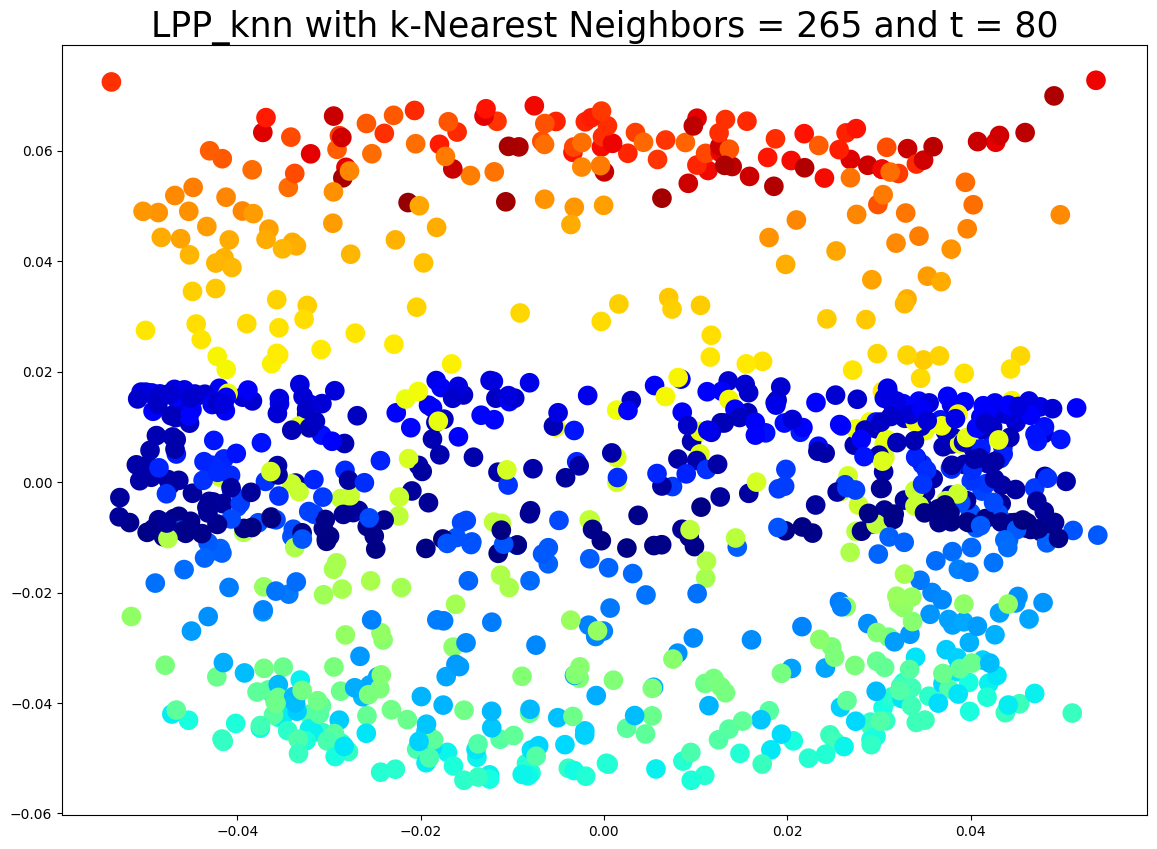

In [405]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['knn']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 1000
        n_neighbors = 300
        lpp_embeddings = LPP(Data_T, d=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP_epsilon with t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 265
        t= 80
        lpp_embeddings = LPP(Data_T, d=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP_knn with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()


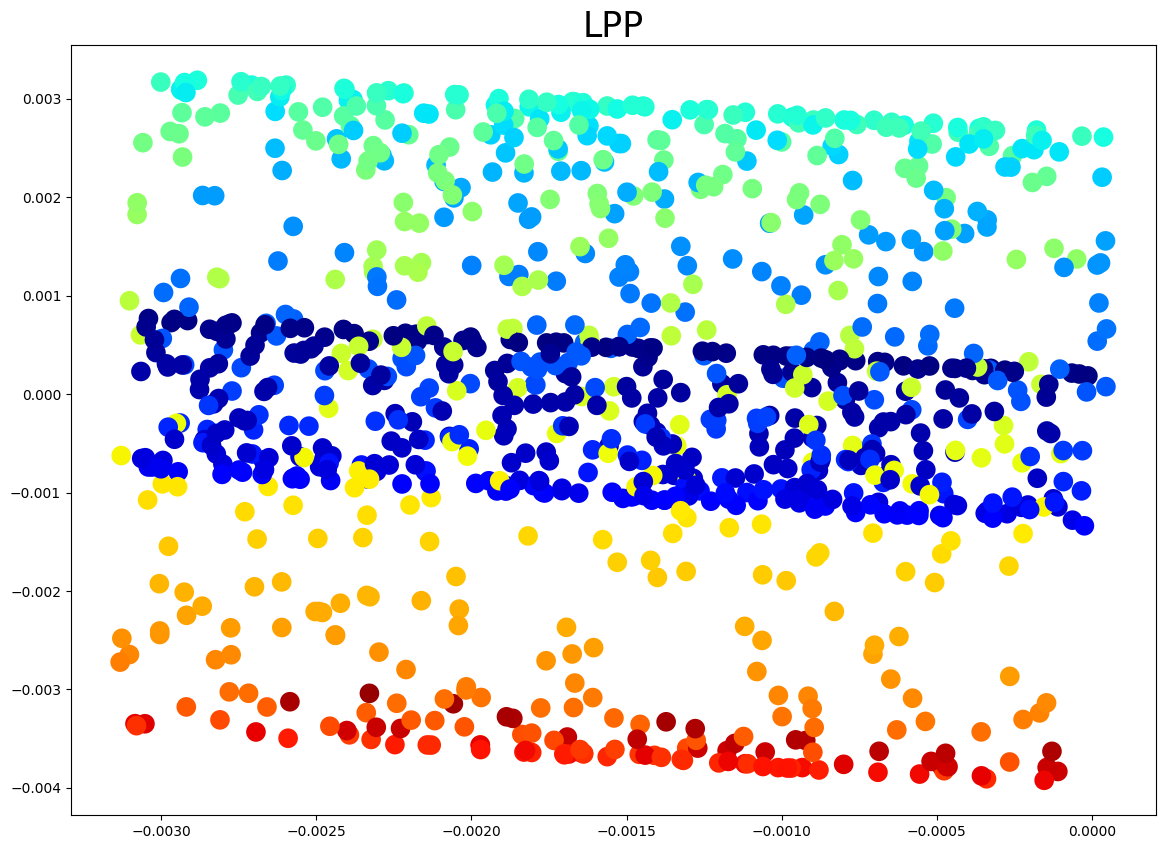

In [406]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)
# 绘制及保存投影图
plt.figure(figsize=(14, 10))
plt.title('LPP', size=25)
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
plt.show()
